## 1. Import the libraries and dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk

# Downloads the NLTK package
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter='\t')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leticiachoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leticiachoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leticiachoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/leticiachoo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/leticiachoo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 2. Text pre-processing

The `SentimentIntensityAnalyzer` uses [**V**alence **A**ware **D**ictionary for s**E**ntiment **R**easoning (VADER)](
https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664?gi=d54850063d7f) algorithm.

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Tokenizer removes punctuations
tokenizer = RegexpTokenizer(r'\w+')

# Lemmatizer
wl = WordNetLemmatizer()

# Stopword remover - we want to keep "not"
sw = stopwords.words('english')
sw.remove('not')
sw = set(sw)

# Sentiment analyzer
sia = SentimentIntensityAnalyzer()


def preprocess(sentence):
    # Tokenize word to split into tokens array
    words = tokenizer.tokenize(sentence.lower())
    words_lem = []
    
    for w in words:
        w = wl.lemmatize(w) if w not in sw else w

        # Remove another round after lemmatized replacement word
        if w not in sw:
            words_lem.append(w)

    return ' '.join(words_lem)

corpus = [preprocess(dataset['Review'][i]) for i in range(0, len(dataset))]
sentiments = [sia.polarity_scores(w) for w in corpus]
scores_pred = [s['compound'] > 0.3612 for s in sentiments]
scores_actual = dataset['Liked']

## 3. Display graph and results

Accuracy score:  0.801 

                Disliked  Liked
Pred. Disliked       432    131
Pred. Liked           68    369


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


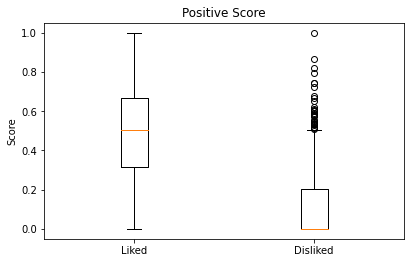


                     Liked  Disliked
Outlier (min)     0.00000  0.508000
Outlier (max)     0.00000  1.000000
Outlier (avg)     0.00000  0.626688
Min               0.00000  0.000000
Max               1.00000  0.505000
Q1 (25%)          0.31600  0.000000
Q2 (50%, median)  0.50500  0.000000
Q3 (75%)          0.66925  0.202500 



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


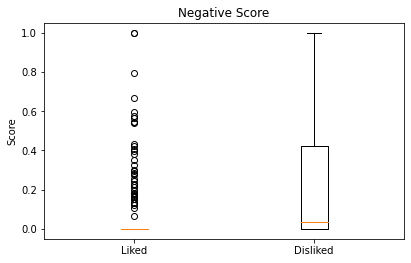


                      Liked  Disliked
Outlier (min)     0.068000   0.00000
Outlier (max)     1.000000   0.00000
Outlier (avg)     0.334227   0.00000
Min               0.000000   0.00000
Max               0.000000   1.00000
Q1 (25%)          0.000000   0.00000
Q2 (50%, median)  0.000000   0.03750
Q3 (75%)          0.000000   0.42375 



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


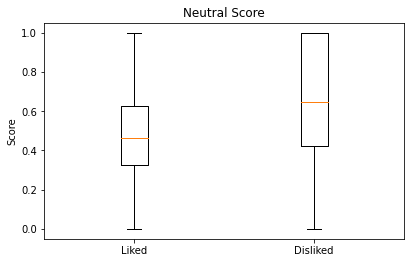


                   Liked  Disliked
Outlier (min)     0.000   0.00000
Outlier (max)     0.000   0.00000
Outlier (avg)     0.000   0.00000
Min               0.000   0.00000
Max               1.000   1.00000
Q1 (25%)          0.328   0.42275
Q2 (50%, median)  0.461   0.64500
Q3 (75%)          0.625   1.00000 



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


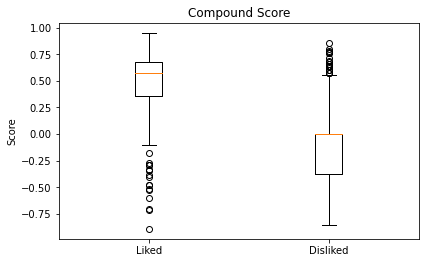


                    Liked  Disliked
Outlier (min)     0.0000  0.571900
Outlier (max)     0.0000  0.855500
Outlier (avg)     0.0000  0.669604
Min              -0.1027 -0.859100
Max               0.9524  0.557400
Q1 (25%)          0.3612 -0.380750
Q2 (50%, median)  0.5719  0.000000
Q3 (75%)          0.6808  0.000000 



In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import json

cm = confusion_matrix(scores_pred, scores_actual)

print('Accuracy score: ', accuracy_score(scores_pred, scores_actual), '\n')
print(pd.DataFrame(cm, columns=['Disliked', 'Liked'], index=['Pred. Disliked', 'Pred. Liked']))


for graph in [
    ('Positive Score', 'pos'),
    ('Negative Score', 'neg'),
    ('Neutral Score', 'neu'),
    ('Compound Score', 'compound')
]:
    fig = plt.figure(figsize =(5, 3))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_ylabel('Score')
    ax.set_title(graph[0])
    ax.set_xticklabels(('Liked', 'Disliked'))
    bp = ax.boxplot([
        [s[graph[1]] for i, s in enumerate(sentiments) if scores_actual[i] == 1],
        [s[graph[1]] for i, s in enumerate(sentiments) if scores_actual[i] == 0], 
    ])
    plt.show()

    outliers = [flier.get_ydata() for flier in bp['fliers']]
    medians = [median.get_ydata() for median in bp['medians']]
    whiskers = [whiskers.get_ydata() for whiskers in bp['whiskers']]
    
    print('\n', pd.DataFrame([
        list(map(lambda i: np.min(outliers[i]) if np.sum(outliers[i]) > 1 else 0, [0,1])),
        list(map(lambda i: np.max(outliers[i]) if np.sum(outliers[i]) > 1 else 0, [0,1])),
        list(map(lambda i: np.average(outliers[i]) if np.sum(outliers[i]) > 1 else 0, [0,1])),
        [whiskers[0][1], whiskers[2][1]],
        [whiskers[1][1], whiskers[3][1]],
        [whiskers[0][0], whiskers[2][0]],
        [medians[0][0], medians[1][0]],
        [whiskers[1][0], whiskers[3][0]]
    ], columns=['Liked', 'Disliked'], index=['Outlier (min)', 'Outlier (max)', 'Outlier (avg)', 'Min', 'Max', 'Q1 (25%)', 'Q2 (50%, median)', 'Q3 (75%)']), '\n')
